In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import cluster, pairwise_distances
from sklearn.manifold import TSNE

from tqdm import tqdm

from FlagRep import FlagRep, truncate_svd, chordal_distance

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import pyplot as plt


In [2]:
def set_seed(seed):
    np.random.seed(seed)                   
    torch.manual_seed(seed)                
    torch.cuda.manual_seed(seed)           
    torch.cuda.manual_seed_all(seed)       
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False  

set_seed(42)


In [3]:


def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)


def make_Bs(fl_type):
    Bs = [np.arange(fl_type[0])]
    for i in range(1,len(fl_type)):
        Bs.append(np.arange(fl_type[i-1],fl_type[i]))
    return Bs


# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        # Input layer to hidden layer 1
        self.fc1 = nn.Linear(input_size, hidden_size)
        # Hidden layer 1 to hidden layer 2
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # Hidden layer 2 to hidden layer 3
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        # Hidden layer 3 to output layer (10 classes)
        self.fc4 = nn.Linear(hidden_size, output_size)
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)  # No activation on the output (for logits)
        return x

In [4]:

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)



In [5]:

# Set up hyperparameters
input_size = 28 * 28  # Flattened image size
hidden_size = 128     # Same size for all hidden layers
output_size = 10      # 10 output classes (digits 0-9)
num_epochs = 10
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = NeuralNetwork(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Flatten the images from (batch_size, 1, 28, 28) to (batch_size, 28*28)
        images = images.view(-1, 28*28)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing the model
model.eval()  # Set the model to evaluation mode (disables dropout, batchnorm, etc.)
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 28*28)  # Flatten images
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


Epoch [1/10], Loss: 0.1267
Epoch [2/10], Loss: 0.1616
Epoch [3/10], Loss: 0.1684
Epoch [4/10], Loss: 0.0883
Epoch [5/10], Loss: 0.3144
Epoch [6/10], Loss: 0.0198
Epoch [7/10], Loss: 0.0160
Epoch [8/10], Loss: 0.0131
Epoch [9/10], Loss: 0.1025
Epoch [10/10], Loss: 0.0071
Test Accuracy: 97.46%


In [6]:
torch.save(model.state_dict(), '../models/mnist_model.pth')


In [7]:
# Set up hyperparameters
input_size = 28 * 28  # Flattened image size
hidden_size = 128     # Same size for all hidden layers
output_size = 10      # 10 output classes (digits 0-9)
num_epochs = 10
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = NeuralNetwork(input_size, hidden_size, output_size)
model.load_state_dict(torch.load('../models/mnist_model.pth'))


/tmp/ipykernel_3918818/457014539.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../models/mnist_model.pth'))


<All keys matched successfully>

In [8]:

# Pass the sample through the network step-by-step without computing gradients
# train_mats = []
# for img,_ in train_dataset:
#     sample_image = img.view(-1, 28*28)
#     with torch.no_grad():
#         # Step-by-step pass through each layer
#         h10 = model.fc1(sample_image)
#         h11 = model.relu(h10)  # Pass through first hidden layer
#         h20 = model.fc2(h11)
#         h21 = model.relu(h20)         # Pass through second hidden layer
#         h30 = model.fc3(h21)
#         h31 = model.relu(h30)         # Pass through third hidden layer

#         hidden_rep = [h.cpu().detach().numpy().T for h in [h10,h11,h20,h21,h30,h31]]
#     train_mats.append(np.hstack(hidden_rep))

# Pass the sample through the network step-by-step without computing gradients
test_mats = []
for img,_ in test_dataset:
    sample_image = img.view(-1, 28*28)
    with torch.no_grad():
        # Step-by-step pass through each layer
        h10 = model.fc1(sample_image)
        h11 = model.relu(h10)  # Pass through first hidden layer
        h20 = model.fc2(h11)
        h21 = model.relu(h20)  # Pass through second hidden layer
        h30 = model.fc3(h21)
        h31 = model.relu(h30)  # Pass through third hidden layer

        # hidden_rep = [h.cpu().detach().numpy().T for h in [h10,h11,h20,h21,h30,h31]]
        hidden_rep = [h.cpu().detach().numpy().T for h in [h20,h21,h30,h31]]
    test_mats.append(np.hstack(hidden_rep))



In [9]:
# As = [np.arange(2),np.arange(4),np.arange(6)]
As = [np.arange(2),np.arange(4)]
# flag_type = [2,4,6]
flag_type = [2,4]
cutoff = .99

In [10]:

flags = {}
flags['FlagRep'] = []
flags['QR'] = []
flags['SVD'] = []

flag_types = {}
flag_types['FlagRep'] = []
flag_types['QR'] = []
flag_types['SVD'] = []

for m in tqdm(test_mats):
    frep, frep_ftype = FlagRep(m, As, eps_rank = cutoff)
    flags['FlagRep'].append(frep)
    flag_types['FlagRep'].append(frep_ftype)

    q, _ = np.linalg.qr(m)
    flags['QR'].append(q)
    flag_types['QR'].append(flag_type)

    u = truncate_svd(m, eps_rank = cutoff)
    flags['SVD'].append(q)
    flag_types['SVD'].append(np.arange(1,np.min([m.shape[1], u.shape[1]])))


100%|██████████| 10000/10000 [00:07<00:00, 1264.93it/s]


In [11]:
np.unique(flag_types['FlagRep'])

array([1, 2])

In [12]:
for method_name in ['FlagRep', 'QR']:

    smallest_dim = np.min([t[-1] for t in flag_types[method_name]])
    flag_types[method_name] = [np.array([t[0],smallest_dim]) for t in flag_types[method_name]]    

In [13]:
flag_types['FlagRep']

[array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([

In [14]:


n_pts = 1000 #len(flags['FlagRep'])
dist_mats = {}
for method_name in ['FlagRep', 'QR', 'SVD']:
    #make distance matrices
    dist_mats[method_name] = np.zeros((n_pts,n_pts))
    for i in tqdm(range(n_pts)):
        for j in range(i+1,n_pts):
            x = flags[method_name][i]
            y = flags[method_name][j]
            if method_name == 'Euclidean':
                dist = np.linalg.norm(x-y)
            else:
                fl_type_x = flag_types[method_name][i]
                fl_type_y = flag_types[method_name][j]
                Bs_x = make_Bs(fl_type_x)
                Bs_y = make_Bs(fl_type_y)
                dist = chordal_distance(x, y, Bs_x, Bs_y)
            dist_mats[method_name][i,j] = dist
            dist_mats[method_name][j,i] = dist
            

100%|██████████| 1000/1000 [00:14<00:00, 66.83it/s]


In [15]:
mod_labels = [l for _, l in test_dataset][:n_pts]

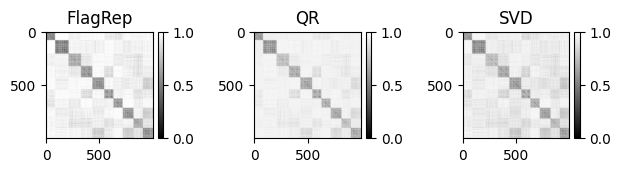

In [16]:


sort_idx = np.argsort(mod_labels)
fig, ax = plt.subplots(1,3)
for i, method_name in enumerate(['FlagRep', 'QR', 'SVD']):
    im = ax[i].imshow(dist_mats[method_name][sort_idx, :][:,sort_idx]/dist_mats[method_name].max(), cmap = 'grey')
    ax[i].set_title(method_name)
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

plt.tight_layout()

In [17]:

test_mats_baseline = []
for img,_ in test_dataset:
    sample_image = img.view(-1, 28*28)
    with torch.no_grad():
        h10 = model.fc1(sample_image)
        h11 = model.relu(h10)  
        h20 = model.fc2(h11)
        h21 = model.relu(h20)         
        h30 = model.fc3(h21)
        h31 = model.relu(h30)         

        hidden_rep = h31.cpu().detach().numpy()
    test_mats_baseline.append(hidden_rep)

small_euc_data = np.vstack(test_mats_baseline)[:n_pts,:]

dist_mats['Euclidean'] = pairwise_distances(small_euc_data, metric='euclidean')

FlagRep:
Purity score: 0.86
QR:
Purity score: 0.786
SVD:
Purity score: 0.774
Euclidean:
Purity score: 0.663


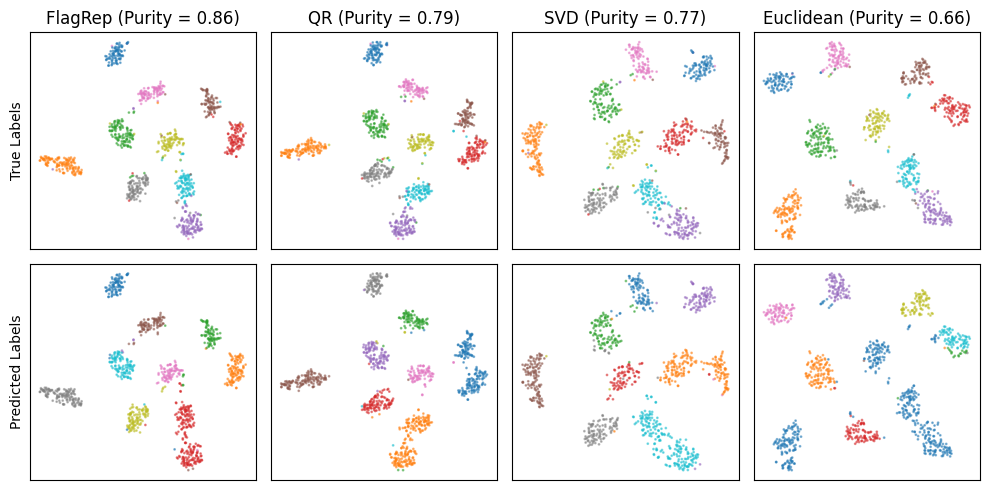

In [18]:

fig, ax = plt.subplots(2, 4, figsize = (10,5))
for a, row in zip(ax[:,0], ['True Labels', 'Predicted Labels']):
    a.set_ylabel(row, rotation=90)

for i, method_name in enumerate(['FlagRep', 'QR', 'SVD', 'Euclidean']):
    tsne = TSNE(n_components=2,metric='precomputed', init = "random", random_state = 10)
    vis_data = tsne.fit_transform(dist_mats[method_name])

    scatter = ax[0,i].scatter(vis_data[:,0], vis_data[:,1], alpha=.5, c=mod_labels, cmap='tab10', s = 1)
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    

    n_clusters = 10  # Define the number of clusters
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
    cluster_labels = clustering.fit_predict(dist_mats[method_name])
    res = purity_score(mod_labels, cluster_labels)
    print(f'{method_name}:')
    print(f'Purity score: {res}')

    ax[1,i].scatter(vis_data[:,0], vis_data[:,1], alpha=.5, c=cluster_labels, cmap='tab10', s = 1)
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])

    # ax[1,i].set_xlabel('t-SNE1')
    ax[0,i].set_title(f'{method_name} (Purity = {np.round(res,2)})')
# ax[0,0].set_ylabel('t-SNE2')
# ax[1,0].set_ylabel('t-SNE2')
# Create a legend with labels
# legend = plt.legend(*scatter.legend_elements(), title="Digits", loc="center right", bbox_to_anchor=(1, 1))
# plt.gca().add_artist(legend)
plt.tight_layout()
# fig.suptitle('t-SNE of MNIST')
plt.savefig('../results/mnist_clusters.pdf', bbox_inches = 'tight')
